In [48]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Using for cleaning and Pre-Processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
en = spacy.load('en_core_web_sm')
# To generate embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS,Phraser
from gensim.models import Word2Vec, KeyedVectors #To load the model
from cleantext import clean
#Visualisations
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Calibri"
import matplotlib.gridspec as gridspec
import os
from datetime import timedelta
from datetime import datetime
from time import time
from tqdm import tqdm



#To check for performance
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
#Importing
new_data=pd.read_csv("extreme right antisemitism _ new.csv")
data=new_data[['Date','Post']]
#Removing Duplicate posts
data=data.drop_duplicates()
print(data.isnull().sum())
data=data.dropna()
#Converting into date type
data['Date']=data['Date'].apply(lambda x:datetime.strptime(str(x),'%d/%m/%y'))
data=data.sort_values(by='Date')
print(data.head())
print(data.shape)
data.post=data.Post.astype(str)

Date    1
Post    1
dtype: int64
            Date                                               Post
6374  2022-12-24  >>409477824 He entire GOP is ZOG. Itâ€™s all a...
12388 2022-12-24                >>409482710 >those kike demon claws
12389 2022-12-24  >>4094824525 % of all americans especially bla...
12390 2022-12-24  >>409477876 he is shit, I watched him briefly ...
12391 2022-12-24  >>409483440 I'm going to take a wild guess tha...
(36037, 2)


## Text Cleaning and Pre-Processing

In [5]:
#Removing links
data['clean']=data['Post'].apply(lambda x:re.sub(r"http\S+","",str(x)))
#Converting letters into lowercase
data['clean']=data['clean'].apply(lambda x: x.lower())
#removing digits
data['clean']=data['clean'].apply(lambda x:re.sub("\d",'',x))
# removing punctuations
data['clean']=data['clean'].apply(lambda x:x.translate(str.maketrans("","",string.punctuation)))
#Include only letters
data['clean']=data['clean'].apply(lambda x:re.sub("[^a-zA-Z]"," ",x))
data.head()

,Date,Post,clean
6374,2022-12-24,>>409477824 He entire GOP is ZOG. Itâ€™s all a...,he entire gop is zog it s all a uniparty no...
12388,2022-12-24,>>409482710 >those kike demon claws,those kike demon claws
12389,2022-12-24,>>4094824525 % of all americans especially bla...,of all americans especially blacks would acc...
12390,2022-12-24,">>409477876 he is shit, I watched him briefly ...",he is shit i watched him briefly when i was y...
12391,2022-12-24,>>409483440 I'm going to take a wild guess tha...,im going to take a wild guess that the guy th...


In [6]:
def bigstring(text):
    new=[]
    for i in text:
        if len(i)<11:
            new.append(i)
    return new
def remove_stopwords(text):
    stopwords1=set(stopwords.words('english'))
    stopwords2= en.Defaults.stop_words
    modified_text=[]
    for i in text:
        if i not in stopwords1 and i not in stopwords2:
            modified_text.append(i)
    return (modified_text)
def lematize(text):
    lematizer=WordNetLemmatizer()
    lema=[]
    for i in text:
        lema.append(lematizer.lemmatize(i))
    return (" ".join(lema))
def pos(text):
    #Filtering terms of particular parts of speech
    p=pos_tag(text)
    pos_removal=[]
    for tag in p:
        if tag[1]=='JJ' or tag[1]=='NN' or tag[1]=='NNS'or tag[1]=='NNP'or tag[1]=='VBP':
            pos_removal.append(tag[0])
    return pos_removal

In [7]:
data['clean']=data['clean'].apply(lambda x:word_tokenize(x))
data['clean']=data['clean'].apply(lambda x:pos(x))
data['clean']=data['clean'].apply(lambda x:bigstring(x))
data['clean']=data['clean'].apply(lambda x:remove_stopwords(x))
data['clean']=data['clean'].apply(lambda x:lematize(x))
data.head()

,Date,Post,clean
6374,2022-12-24,>>409477824 He entire GOP is ZOG. Itâ€™s all a...,entire gop uniparty stage aipac
12388,2022-12-24,>>409482710 >those kike demon claws,kike demon claw
12389,2022-12-24,>>4094824525 % of all americans especially bla...,american black kike killer mission rest anit b...
12390,2022-12-24,">>409477876 he is shit, I watched him briefly ...",shit nowadays he horrendous check channel lock...
12391,2022-12-24,>>409483440 I'm going to take a wild guess tha...,im wild guess guy thread time meme flag kike


## Extracting top n-terms for each time phase

In [8]:
def emerging(starting_date,window,terms):
    x=pd.to_datetime(starting_date)
    windowsize=window
    glossary=['kike','zog','george soros','rothschild']
    important_terms={}
    z=1
    check=True
    if x>data['Date'].max():
        return 'Check the starting date'
    
    while(tqdm(check)):
        #For each time step
        if (x+timedelta(days=windowsize))>=data['Date'].max():
            y=data['Date'].max()
            check=False
        else:
            y=(x+timedelta(days=windowsize))
        data1=data.clean[(data['Date']>=x)&(data['Date']<y)]
        text=' '.join(data1)
        x=x+timedelta(days=windowsize)
        #Generate TF-IDF Matrix
        tf_idfvectorizer=TfidfVectorizer(ngram_range=(2,2))
        tfidf=tf_idfvectorizer.fit_transform(data1)
        features=tf_idfvectorizer.get_feature_names_out()
        
        #Exporting all Bigrams
        #pd.DataFrame(features).to_csv("Bigrams "+str(z)+".csv",header=['All Bigrams'])
        
        #Finding Emerging terms/Initializing glossary
        emerging_terms=[]
        for i in features:
            if i not in glossary:
                emerging_terms.append(i)
                #glossary.append(i)
        
        #Finding the index of emerging terms
        findex=[i for i,word in enumerate(features) if word in emerging_terms ]
        
        #Finding the highest tf-idf value for all the feature names across all documents
        tfidf_values={}
        for column in tqdm(findex):
            high=0
            for row in range(tfidf.shape[0]):
                if tfidf[row,column]>high:
                    high=tfidf[row,column]
            tfidf_values[features[column]]=high
        
        tfidf_values=sorted(tfidf_values.items(),key=lambda x:x[1],reverse=True)
        
        #Exporting Top Tf-idf values with bigrams
        
        #pd.DataFrame(tfidf_values).to_csv("SubtractionBigram-Tfidf "+str(z)+".csv",header  = ['Bigrams','TF-IDF Values'])
        #print(tfidf_values[:20])
    
        #Extracting bigrams after TF-IDF threshold cut off
        a=0
        for i in tfidf_values:
            a=a+i[1]
        print("Threshold for "+str(z)+ "window",a/len(tfidf_values))
        final_tfidf={}
        for i in tfidf_values:
            if i[1]>a/len(tfidf_values):
                final_tfidf[i[0]]=i[1]
            else:
                glossary.append(i[0])
        #Exporting Tf-idf values above threshold
        #pd.DataFrame.from_dict(data=final_tfidf, orient='index').to_csv("Bigram_threshold "+str(z)+".csv",index_label='Bigrams',header  = ['TF-IDF Values'])
        
        #Frequency of words in that window size
        words_frequency={}
        text1=text.split(" ")
        pairs=list(zip(text1[:-1],text1[1:]))
        bigrams=[' '.join(i) for i in pairs]
        for word in (final_tfidf.keys()):
            words_frequency[word]=0
            for i in bigrams:
                if word==i:
                    words_frequency[word]=words_frequency[word]+1
                
        words_frequency=sorted(words_frequency.items(),key=lambda x:x[1],reverse=True)
        
        #Appending terms in Imp terms list
        for i in range(terms):
            important_terms[words_frequency[i][0]]=words_frequency[i][1]
        # Frequency for Important terms
        for key in important_terms.keys():
            important_terms[key]=0
            for i in bigrams:
                if key==i:
                    important_terms[key]=important_terms[key]+1
        
        
        # Exporting Bigrams with frequency
        #pd.DataFrame(words_frequency).to_csv("Bigram_frequency "+str(z)+".csv",header  = ['Bigrams','Frequency'])
        
        #Exporting Important terms that is coming from  window
        pd.DataFrame.from_dict(data=important_terms, orient='index').to_csv("Important_terms "+str(z)+".csv",index_label='Bigrams',header  = ['Frequency'])

        
        #Ploting the graph
        x_label=[]
        y_label=[]
        for i in range(terms):
            x_label.append(words_frequency[i][0])
            glossary.append(words_frequency[i][0])
        for i in range(terms):
            y_label.append(words_frequency[i][1])
        plt.figure(figsize=(20,5))
        plt.bar(range(len(x_label)),y_label,tick_label=x_label)

        plt.show()
        z=z+1


0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 73070/73070 [2:07:51<00:00,  9.52it/s]


Threshold for 1window 0.1761295578373303


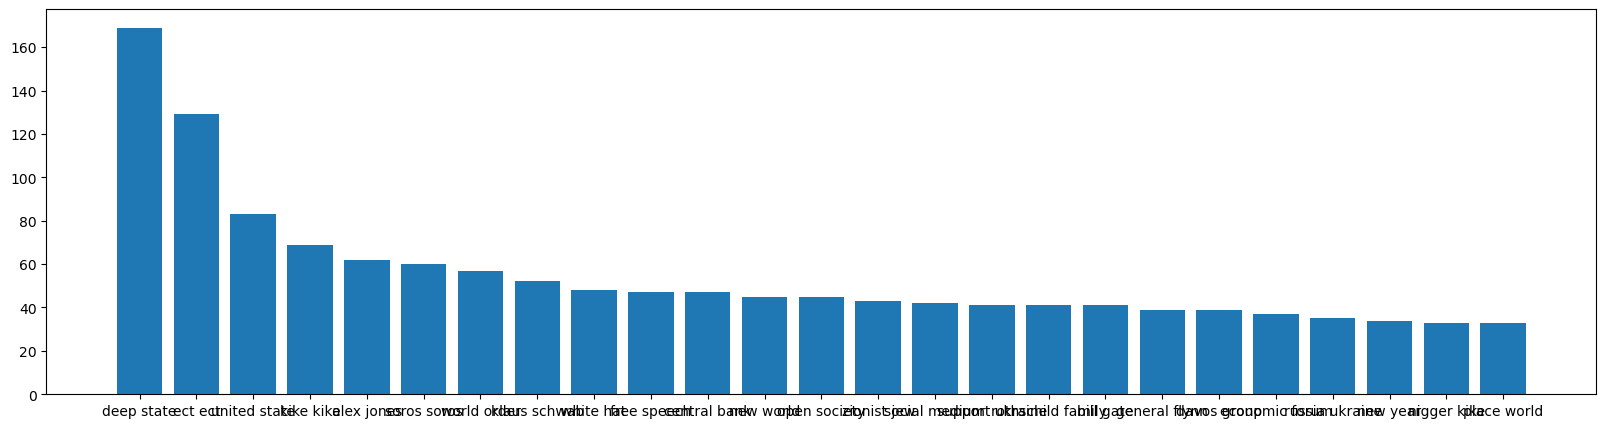

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 86368/86368 [1:06:27<00:00, 21.66it/s]


Threshold for 2window 0.1667538114904102


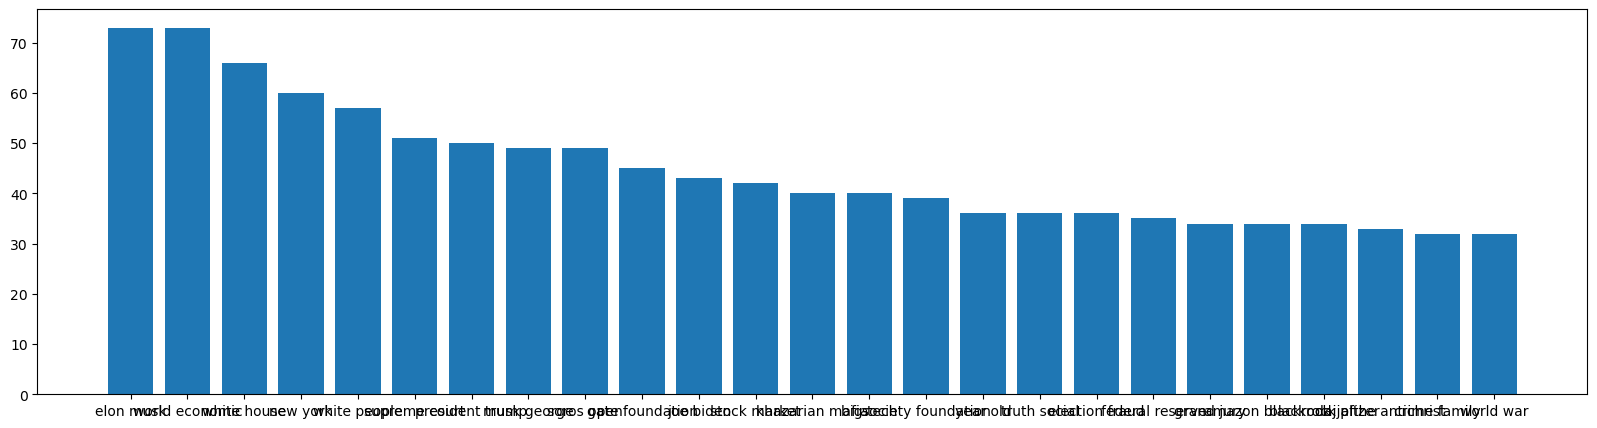

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 96082/96082 [1:37:05<00:00, 16.49it/s]


Threshold for 3window 0.17779101467975772


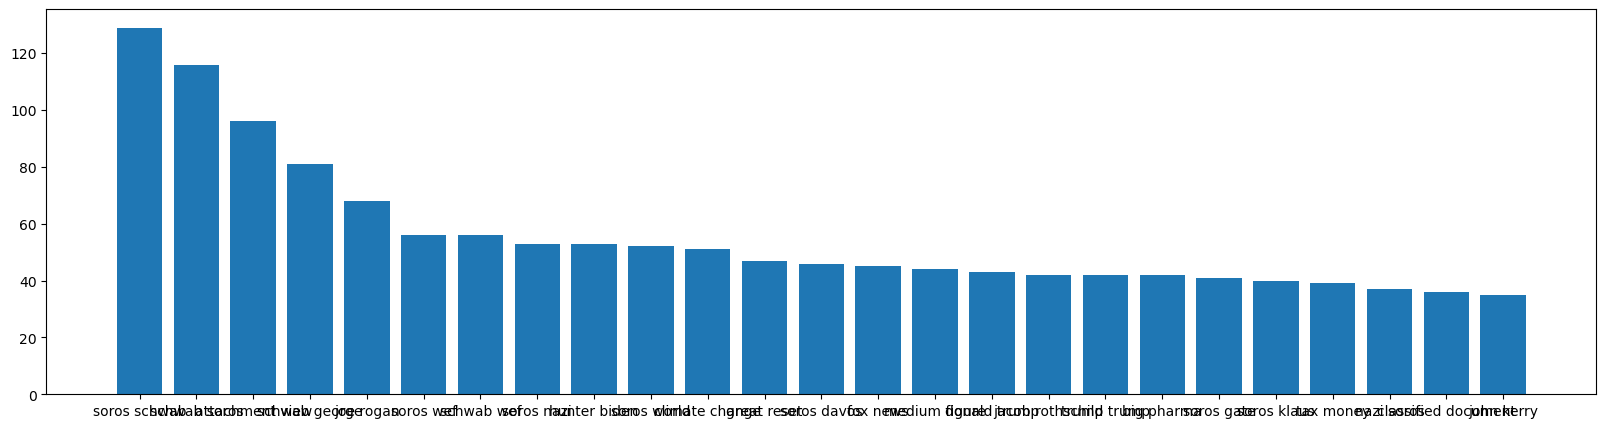

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 87349/87349 [1:20:45<00:00, 18.03it/s]


Threshold for 4window 0.1730403510324544


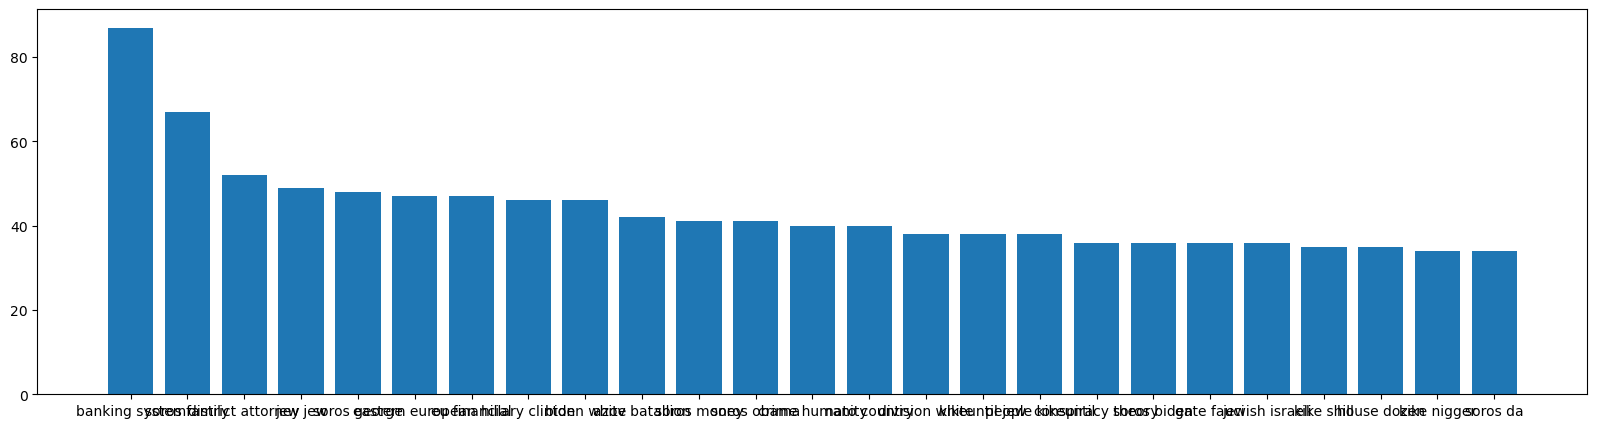

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 81774/81774 [1:50:43<00:00, 12.31it/s]


Threshold for 5window 0.16741165576216588


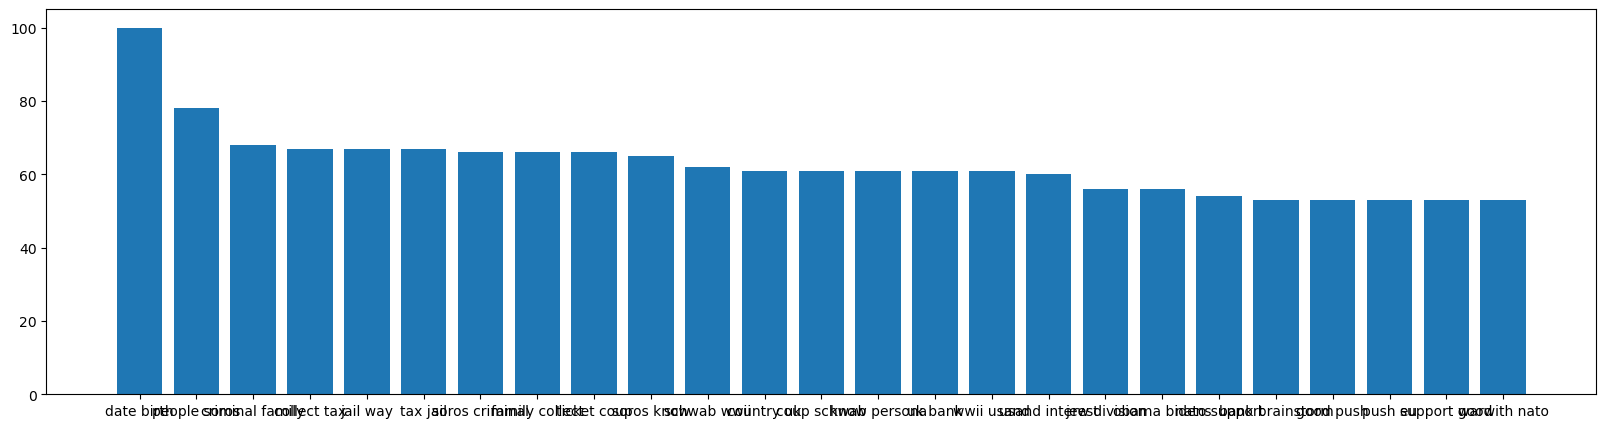

0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 74250/74250 [1:24:49<00:00, 14.59it/s]


Threshold for 6window 0.1846764421274033


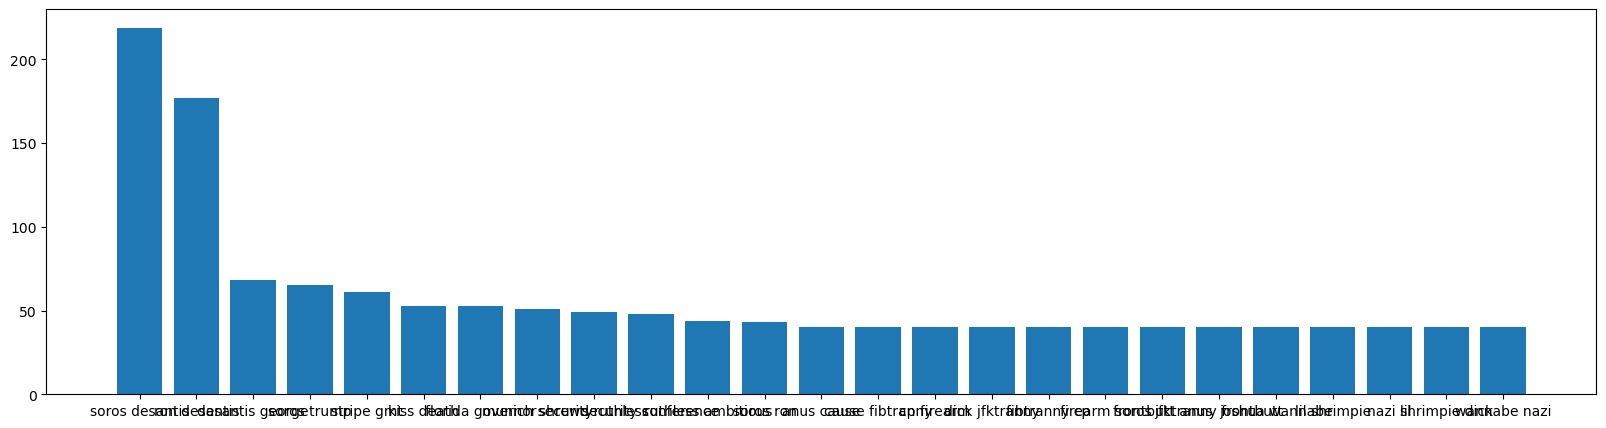

0it [00:00, ?it/s]


In [9]:
emerging(starting_date='2022-12-24',window=10,terms=25)

## Training a word2vec model

In [12]:
## Preprocessing and cleaning. 
# Including all the parts of speech words for training word2vec model.

In [13]:
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

In [14]:
data['Cleaned Text']=data['Post'].apply(lambda x:re.sub(r"https\S+","",str(x)))
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:x.lower())
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:re.sub("\d","",x))
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:x.translate(str.maketrans("","",string.punctuation)))
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:emoji_pattern.sub(r"",x))
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:re.sub("[^a-zA-Z]"," ",x))


In [15]:
def lematize(text):
    lematizer=WordNetLemmatizer()
    lema=[]
    for i in text:
        lema.append(lematizer.lemmatize(i))
    return lema
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:word_tokenize(x))
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:bigstring(x))
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:remove_stopwords(x))
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:lematize(x))
data.head()

,Date,Post,clean,Cleaned Text
6374,2022-12-24,>>409477824 He entire GOP is ZOG. Itâ€™s all a...,entire gop uniparty stage aipac,"[entire, gop, zog, uniparty, getting, stage, a..."
12388,2022-12-24,>>409482710 >those kike demon claws,kike demon claw,"[kike, demon, claw]"
12389,2022-12-24,>>4094824525 % of all americans especially bla...,american black kike killer mission rest anit b...,"[american, especially, black, accept, kike, ki..."
12390,2022-12-24,">>409477876 he is shit, I watched him briefly ...",shit nowadays he horrendous check channel lock...,"[shit, watched, briefly, younger, nowadays, he..."
12391,2022-12-24,>>409483440 I'm going to take a wild guess tha...,im wild guess guy thread time meme flag kike,"[im, going, wild, guess, guy, bumped, thread, ..."


In [16]:
#Using Phrases function to get bi-grams merged with underscore 
text=data['Cleaned Text']
phrases=Phrases(text,threshold=5,min_count=5,connector_words=ENGLISH_CONNECTOR_WORDS)

In [17]:
def sentence_to_bigram(sent):
    return phrases[sent]
#Runing phrases object on each document(tweet)
data['Cleaned Text']=data['Cleaned Text'].apply(lambda x:sentence_to_bigram(x))
data['Cleaned Text']

6374     [entire, gop, zog, uniparty, getting, stage, a...
12388                                  [kike, demon, claw]
12389    [american, especially, black, accept, kike, ki...
12390    [shit, watched, briefly, younger, nowadays, he...
12391    [im_going, wild, guess, guy, bumped, thread, t...
                               ...                        
23567    [kike, use, type, sluryou, reek, reddit, retar...
23566                   [shes, kike, real, rachel, seidel]
23565    [soon, dy, national_socialism, rise, left, wil...
23580                                           [he, kike]
38504    [der, plan, de, deep_state, ist_die, menschhei...
Name: Cleaned Text, Length: 36037, dtype: object

In [18]:
#model=Word2Vec(data['Cleaned Text'], min_count=5, vector_size=200, window = 5, sg = 1)
#model.save('rightantisemiw2v_model')
#Using the saved word2vec model
model=Word2Vec.load('rightantisemiw2v_model')

## Checking for semantically related to antisemitic discourse

In [45]:
#Importing all 150 important terms,all terms till window 6.
window6=pd.read_csv("Important_terms 6.csv")
bigrams_tfidf=list(window6['Bigrams'])
tfidf_bigram=['_'.join(i.split()) for i in bigrams_tfidf]
print(tfidf_bigram[1:10])


['deep_state', 'ect_ect', 'united_state', 'kike_kike', 'alex_jones', 'soros_soros', 'world_order', 'klaus_schwab', 'white_hat']


In [21]:
len(tfidf_bigram)


150

In [47]:
# Antisemetic terms used for extracting tweets.
intial_glossary_used=['zog','kike','george_soros','rothschild']
similarity_df=pd.DataFrame(columns=['Term','zog','kike','george soros','rothschild','Average'])

In [48]:
# Getting semantic similarity socre for each important terms to all antisemetic terms
similarity_scores=[]
for bigram in tfidf_bigram:
    vec=np.random.uniform(-0.0001,-0.00001,200)
    score=[bigram]
    s=0
    for anti in intial_glossary_used:
        try:
            sim=model.wv.similarity(bigram,anti)
            score.append(sim)
            s=s+sim
        except KeyError:
            cos_sim=np.dot(vec,model.wv[anti])/(np.linalg.norm(vec)*np.linalg.norm(model.wv[anti]))
            score.append(cos_sim)
            s=s+cos_sim
    score.append(s/5)
    similarity_df.loc[len(similarity_df)]=score

In [49]:
# Setting up the threshold
threshold=sum(similarity_df['Average'])/len(similarity_df['Average'])
similarity_df['predict']=similarity_df.Average.apply(lambda x:1 if x>threshold else 0)
threshold

0.11108463345245025

In [50]:
similarity_df

,Term,zog,kike,george soros,rothschild,Average,predict
0,george_soros,0.236617,0.163366,1.000000,0.133440,0.306684,1
1,deep_state,0.201637,0.150942,0.400054,0.217507,0.194028,1
2,ect_ect,0.105124,0.014445,0.172354,0.192081,0.096801,0
3,united_state,0.141195,0.111539,0.225366,0.059033,0.107427,0
4,kike_kike,0.031003,-0.082216,-0.071066,-0.047804,-0.034017,0
...,...,...,...,...,...,...,...
145,joshua_wannabe,0.169731,0.192831,0.081686,0.073486,0.103547,0
146,lil_shrimpie,0.160173,0.189572,0.067343,0.072293,0.097876,0
147,nazi_lil,0.169937,0.203317,0.062534,0.067669,0.100691,0
148,shrimpie_dick,0.162507,0.190776,0.076720,0.073485,0.100698,0


In [26]:
# Saving as a data frame
#pd.DataFrame(similarity_df).to_csv('bigram_similarity_df.csv')
#Importing after assigning true labels for these terms to check for the performace of the model
similarity_df=pd.read_csv("bigram_similarity_df.csv")

In [27]:
true=list(similarity_df['true_label'])
predict=list(similarity_df['predict'])

In [30]:
print("Accuracy Score :",accuracy_score(true,predict))
print("Precision Score :",precision_score(true,predict))
print("Recall Score :",recall_score(true,predict))
print("F1_Score :",f1_score(true,predict))


Accuracy Score : 0.76
Precision Score : 0.6626506024096386
Recall Score : 0.873015873015873
F1_Score : 0.7534246575342466


In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,predict)

array([[59, 28],
       [ 8, 55]])

## Monitoring the terms that are antisemetic by both predicted and true labels.

In [40]:
# Selecting terms that are both antisemetic by true label and predicted label
similarity_df=similarity_df[(similarity_df['true_label']==1) & (similarity_df['predict']==1)]
imp_terms=list(similarity_df['Term'])
imp_terms=[' '.join(i.split('_')) for i in imp_terms]
imp_terms.insert(0,'date')
imp_terms

['date',
 'george soros',
 'deep state',
 'alex jones',
 'world order',
 'klaus schwab',
 'white hat',
 'free speech',
 'new world',
 'open society',
 'zionist jew',
 'social medium',
 'support ukraine',
 'rothschild family',
 'davos group',
 'economic forum',
 'russia ukraine',
 'nigger kike',
 'elon musk',
 'world economic',
 'white people',
 'joe biden',
 'khazarian mafia',
 'election fraud',
 'crime family',
 'world war',
 'soros schwab',
 'joe rogan',
 'schwab wef',
 'hunter biden',
 'climate change',
 'jacob rothschild',
 'big pharma',
 'tax money',
 'banking system',
 'district attorney',
 'eastern european',
 'biden white',
 'crime humanity',
 'division white',
 'kikeuntil jew',
 'people kikeuntil',
 'conspiracy theory',
 'gate fauci',
 'jewish israeli',
 'kike shill',
 'house dozen',
 'kike nigger',
 'warwith nato',
 'ron desantis',
 'kiss death',
 'florida governor',
 'munich security',
 'shrewd ruthless',
 'security conference',
 'firearm soros']

In [41]:
def terms_frequency(starting_date,windowsize):
    df=pd.DataFrame(columns=imp_terms)
    x=pd.to_datetime(starting_date)
    r={}
    check=True
    if x>data['Date'].max():
        return 'Check the starting date'
    
    while(check):
        r['date']=x
        if (x+timedelta(days=windowsize))>=data['Date'].max():
            y=data['Date'].max()
            check=False
        else:
            y=(x+timedelta(days=windowsize))
        data1=data['clean'][(data['Date']>=x)&(data['Date']<y)]
        text=' '.join(data1)
        x=x+timedelta(days=windowsize)
        
        text1=text.split(" ")
        #bigrams
        pairs=list(zip(text1[:-1],text1[1:]))
        bigrams=[' '.join(i) for i in pairs]
        for i in range(1,len(imp_terms)):
            r[imp_terms[i]]=0
            for j in bigrams:
                if j==imp_terms[i] or imp_terms[i] in j:
                    r[imp_terms[i]]=r[imp_terms[i]]+1
        df=df.append(r,ignore_index = True)
        
    return df
        

In [42]:
new=terms_frequency(starting_date='2022-12-24',windowsize=10)

In [43]:
new

,date,george soros,deep state,alex jones,world order,klaus schwab,white hat,free speech,new world,open society,...,house dozen,kike nigger,warwith nato,ron desantis,kiss death,florida governor,munich security,shrewd ruthless,security conference,firearm soros
0,2022-12-24,501,172,62,57,54,48,70,45,45,...,0,28,0,1,0,0,0,0,0,0
1,2023-01-03,670,194,7,92,68,61,33,78,122,...,0,26,0,5,0,0,1,0,1,0
2,2023-01-13,974,126,33,128,208,49,12,120,125,...,0,30,0,13,0,7,2,0,4,0
3,2023-01-23,1141,142,15,111,58,46,12,102,224,...,35,34,0,5,0,0,0,0,0,0
4,2023-02-02,602,118,24,86,54,40,10,77,143,...,1,34,53,19,0,1,0,0,0,0
5,2023-02-12,1030,144,23,57,84,29,11,50,129,...,1,31,1,178,53,53,51,49,48,40


In [ ]:
# Save as csv for later visualisations.
pd.DataFrame(new).to_csv("bigrams_Antisemitism_terms.csv")

## Visualisation and Monitoring Terms

In [2]:
def trending(df, i):
    plt.figure(figsize=(5, 3))
    plt.bar(df['Bigrams'], df['TF-IDF Values'], color='purple')
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Trending Bi-grams')
    plt.ylabel('Frequency')
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.01)
    plt.tight_layout()
    plt.savefig('window_'+str(i)+'.pdf')
    plt.show()

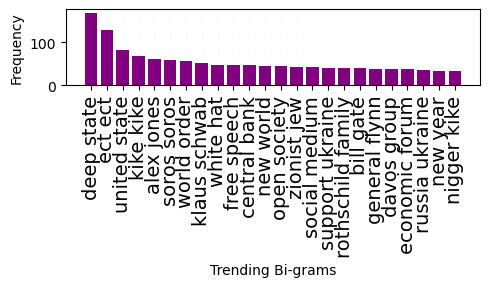

In [14]:
df  = pd.read_csv('Important_terms 1.csv')
df = df.drop(index=0)
trending(df,1)

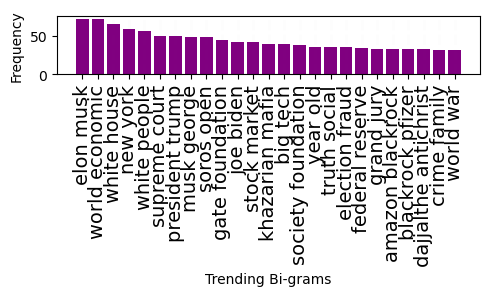

In [15]:
df_2  = pd.read_csv('Important_terms 2.csv')
df_2 = df_2[25:51]
trending(df_2,2)

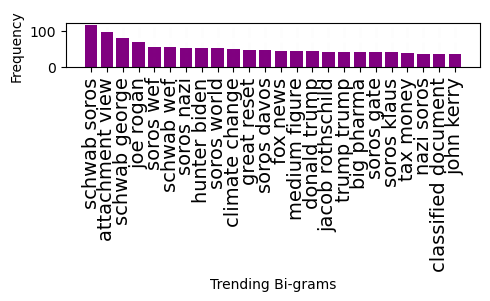

In [16]:
df_3  = pd.read_csv('Important_terms 3.csv')
df_3 = df_3[51:76]
trending(df_3,3)

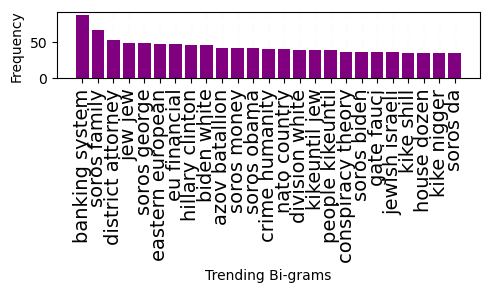

In [17]:
df_4  = pd.read_csv('Important_terms 4.csv')
df_4 = df_4[75:101]
trending(df_4,4)

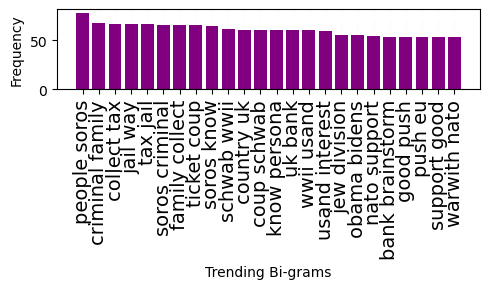

In [18]:
df_5  = pd.read_csv('Important_terms 5.csv')
df_5 = df_5[101:125]
trending(df_5,5)

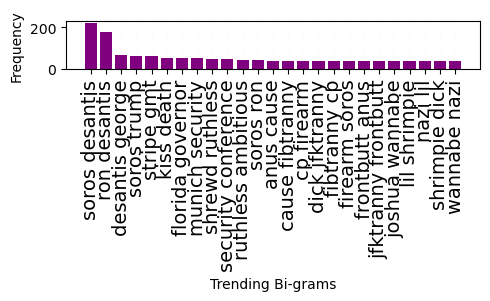

In [19]:
df_6  = pd.read_csv('Important_terms 6.csv')
df_6 = df_6[125:150]
trending(df_6,6)

In [38]:
ev=pd.read_csv("bigrams_Antisemitism_terms.csv")
steps = ['03/01/23','13/01/23','23/01/23', '02/02/23', '12/02/23', '22/02/23']
ev.head().iloc[:,1:]

,date,george soros,deep state,alex jones,world order,klaus schwab,white hat,free speech,new world,open society,...,house dozen,kike nigger,warwith nato,ron desantis,kiss death,florida governor,munich security,shrewd ruthless,security conference,firearm soros
0,24/12/22,501,172,62,57,54,48,70,45,45,...,0,28,0,1,0,0,0,0,0,0
1,03/01/23,670,194,7,92,68,61,33,78,122,...,0,26,0,5,0,0,1,0,1,0
2,13/01/23,974,126,33,128,208,49,12,120,125,...,0,30,0,13,0,7,2,0,4,0
3,23/01/23,1141,142,15,111,58,46,12,102,224,...,35,34,0,5,0,0,0,0,0,0
4,02/02/23,602,118,24,86,54,40,10,77,143,...,1,34,53,19,0,1,0,0,0,0


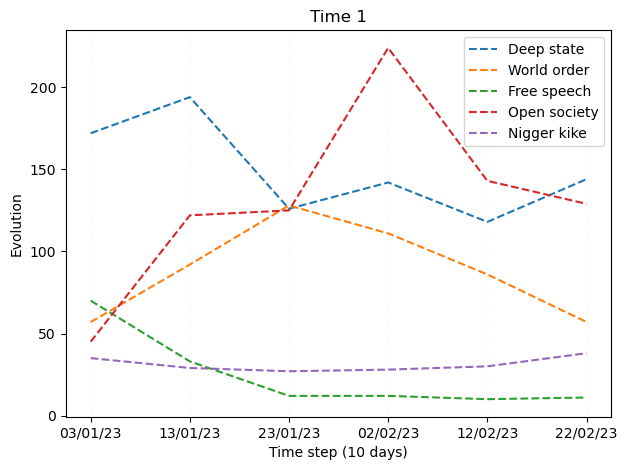

In [49]:
plt.title("Time 1")
plt.plot(steps, ev['deep state'], label='Deep state', linestyle='--')
plt.plot(steps, ev['world order'], label='World order', linestyle='--');
plt.plot(steps, ev['free speech'], label='Free speech', linestyle='--');
plt.plot(steps, ev['open society'], label='Open society', linestyle='--');
plt.plot(steps, ev['nigger kike'], label='Nigger kike', linestyle='--');
#plt.xticks(rotation=90)
plt.ylabel('Evolution')
plt.xlabel('Time step (10 days)')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.01)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('window_1_ev.pdf')
plt.savefig('window_1_ev.png')
plt.show()

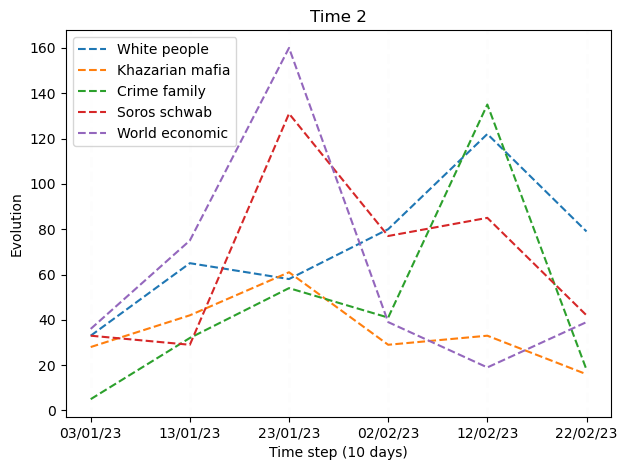

In [50]:
plt.title("Time 2")
#plt.figure(figsize=(5, 3))
#steps = ['Dec 2022','20','30', '40', '50', 'Feb 2023']
plt.plot(steps, ev['white people'], label='White people', linestyle='--')
plt.plot(steps, ev['khazarian mafia'], label='Khazarian mafia', linestyle='--');
plt.plot(steps, ev['crime family'], label='Crime family', linestyle='--');
plt.plot(steps, ev['soros schwab'], label='Soros schwab', linestyle='--');
plt.plot(steps, ev['world economic'], label='World economic', linestyle='--');
#plt.xticks(rotation=90)
plt.ylabel('Evolution')
plt.xlabel('Time step (10 days)')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.01)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('window_2_ev.pdf')
plt.savefig('window_2_ev.png')
plt.show()

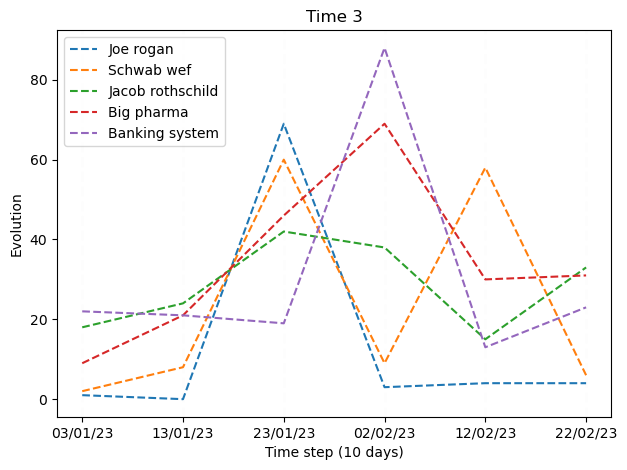

In [51]:
plt.title("Time 3")
#plt.figure(figsize=(5, 3))
#steps = ['Dec 2022','20','30', '40', '50', 'Feb 2023']
plt.plot(steps, ev['joe rogan'], label='Joe rogan', linestyle='--')
plt.plot(steps, ev['schwab wef'], label='Schwab wef', linestyle='--');
plt.plot(steps, ev['jacob rothschild'], label='Jacob rothschild', linestyle='--');
plt.plot(steps, ev['big pharma'], label='Big pharma', linestyle='--');
plt.plot(steps, ev['banking system'], label='Banking system', linestyle='--');
#plt.xticks(rotation=90)
plt.ylabel('Evolution')
plt.xlabel('Time step (10 days)')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.01)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('window_3_ev.pdf')
plt.savefig('window_3_ev.png')
plt.show()

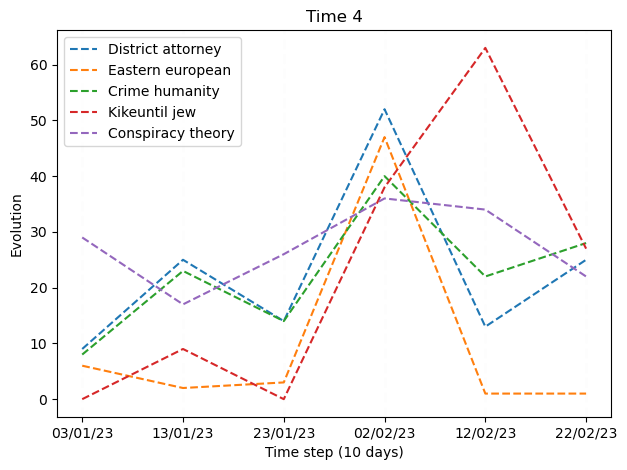

In [52]:
plt.title("Time 4")
#plt.figure(figsize=(5, 3))
#steps = ['Dec 2022','20','30', '40', '50', 'Feb 2023']
plt.plot(steps, ev['district attorney'], label='District attorney', linestyle='--')
plt.plot(steps, ev['eastern european'], label='Eastern european', linestyle='--');
plt.plot(steps, ev['crime humanity'], label='Crime humanity', linestyle='--');
plt.plot(steps, ev['kikeuntil jew'], label='Kikeuntil jew', linestyle='--');
plt.plot(steps, ev['conspiracy theory'], label='Conspiracy theory', linestyle='--');
#plt.xticks(rotation=90)
plt.ylabel('Evolution')
plt.xlabel('Time step (10 days)')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.01)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('window_4_ev.pdf')
plt.show()

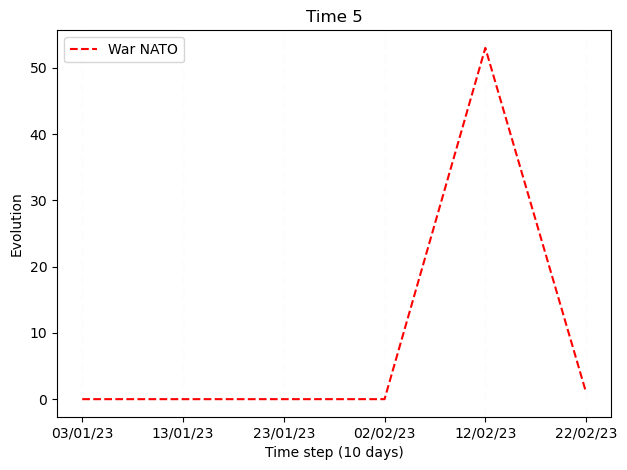

In [53]:
plt.title("Time 5")
plt.plot(steps, ev['warwith nato'], label='War NATO', linestyle='--', color='red')
#plt.xticks(rotation=90)
plt.ylabel('Evolution')
plt.xlabel('Time step (10 days)')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.01)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('window_5_ev.pdf')
plt.show()

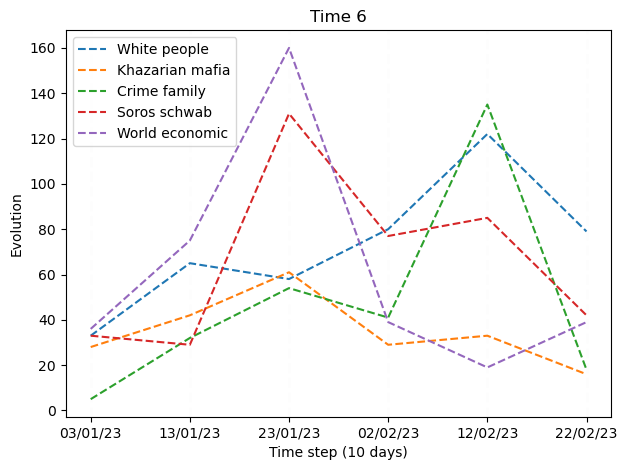

In [54]:
plt.title("Time 6")
#plt.figure(figsize=(5, 3))
#steps = ['Dec 2022','20','30', '40', '50', 'Feb 2023']
plt.plot(steps, ev['white people'], label='White people', linestyle='--')
plt.plot(steps, ev['khazarian mafia'], label='Khazarian mafia', linestyle='--');
plt.plot(steps, ev['crime family'], label='Crime family', linestyle='--');
plt.plot(steps, ev['soros schwab'], label='Soros schwab', linestyle='--');
plt.plot(steps, ev['world economic'], label='World economic', linestyle='--');
#plt.xticks(rotation=90)
plt.ylabel('Evolution')
plt.xlabel('Time step (10 days)')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.01)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig('window_2_ev.pdf')
plt.savefig('window_2_ev.png')
plt.show()